<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


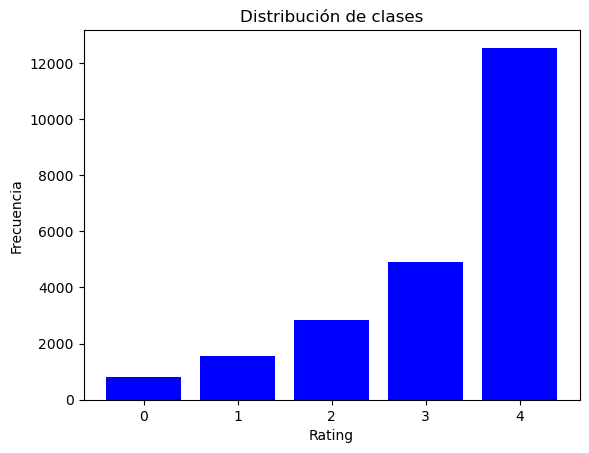

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase
value_counts = df_reviews['Rating'].value_counts()
plt.bar(value_counts.index, value_counts.values, color='blue')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de clases')

# Mostrar el gráfico
plt.show()

Se observa que está desbalanceado

In [7]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [8]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [9]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [10]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [11]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [12]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [13]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [14]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [15]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')
index_word = tok.index_word
print(index_word)

tamaño de vocabulario : 14847
{1: 'the', 2: 'i', 3: 'and', 4: 'a', 5: 'it', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'on', 12: 'for', 13: 'of', 14: 'with', 15: 'was', 16: 'so', 17: 'my', 18: 'dress', 19: 'not', 20: 'that', 21: 'love', 22: 'size', 23: 'very', 24: 'have', 25: 'top', 26: 'fit', 27: 'are', 28: 'like', 29: 'be', 30: 'as', 31: 'me', 32: 'wear', 33: "it's", 34: 'great', 35: 'too', 36: "i'm", 37: 'or', 38: 'am', 39: 'just', 40: 'you', 41: 'would', 42: 'they', 43: 'up', 44: 'at', 45: 'fabric', 46: 'small', 47: 'color', 48: 'look', 49: 'if', 50: 'more', 51: 'really', 52: 'ordered', 53: 'little', 54: 'perfect', 55: 'will', 56: 'one', 57: 'these', 58: 'flattering', 59: 'well', 60: 'an', 61: 'soft', 62: 'out', 63: 'back', 64: 'because', 65: 'had', 66: 'can', 67: '\r', 68: 'comfortable', 69: 'cute', 70: 'nice', 71: 'than', 72: 'bought', 73: 'beautiful', 74: 'when', 75: 'all', 76: 'looks', 77: 'bit', 78: 'fits', 79: 'large', 80: 'shirt', 81: 'down', 82: 'which', 83: 'mate

In [16]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [17]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


In [18]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [19]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [20]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
from keras.utils import to_categorical
y1 = df_reviews['Rating'].values

y = to_categorical(y1, num_classes=5)
print(y.shape)

(22641, 5)


In [21]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [23]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.metrics import AUC

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=[AUC(multi_label=True)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [25]:
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 27s 60ms/step - loss: 0.8948 - auc: 0.8250 - val_loss: 0.9217 - val_auc: 0.8213
Epoch 2/5
453/453 [==============================] - 40s 89ms/step - loss: 0.8308 - auc: 0.8555 - val_loss: 0.9048 - val_auc: 0.8319
Epoch 3/5
453/453 [==============================] - 30s 65ms/step - loss: 0.7823 - auc: 0.8748 - val_loss: 0.9124 - val_auc: 0.8339
Epoch 4/5
453/453 [==============================] - 31s 68ms/step - loss: 0.7354 - auc: 0.8903 - val_loss: 0.9261 - val_auc: 0.8309
Epoch 5/5
453/453 [==============================] - 31s 69ms/step - loss: 0.6994 - auc: 0.9007 - val_loss: 0.9663 - val_auc: 0.8235


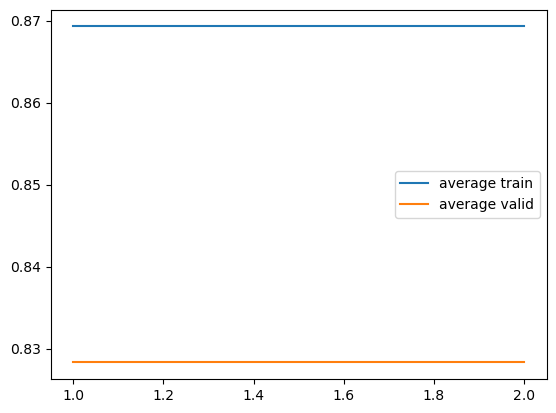

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train_auc_matrix = np.array(hist.history['auc'])
val_auc_matrix = np.array(hist.history['val_auc'])

average_train_auc = np.mean(train_auc_matrix)
average_val_auc = np.mean(val_auc_matrix)

epoch_count = range(1, 3)

# Graficar las curvas de AUC promedio para todas las clases en el conjunto de entrenamiento
sns.lineplot(x=epoch_count, y=average_train_auc, label='average train')

# Graficar las curvas de AUC promedio para todas las clases en el conjunto de validación
sns.lineplot(x=epoch_count, y=average_val_auc, label='average valid')

plt.show()





In [28]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 17ms/step - loss: 0.9063 - auc: 0.8364


[0.906336784362793, 0.8363615274429321]

# Balanceo del dataset

In [29]:
df_reviews['Rating'].value_counts()


4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

In [30]:
# Submuestreo
import pandas as pd
from sklearn.utils import resample

df_class_0 = df_reviews[df_reviews['Rating'] == 0]
df_class_1 = df_reviews[df_reviews['Rating'] == 1]
df_class_2 = df_reviews[df_reviews['Rating'] == 2]
df_class_3 = df_reviews[df_reviews['Rating'] == 3]
df_class_4 = df_reviews[df_reviews['Rating'] == 4]

df_class_0_undersampled = resample(df_class_0, replace=False, n_samples=821, random_state=42)
df_class_1_undersampled = resample(df_class_1, replace=False, n_samples=821, random_state=42)
df_class_2_undersampled = resample(df_class_2, replace=False, n_samples=821, random_state=42)
df_class_3_undersampled = resample(df_class_3, replace=False, n_samples=821, random_state=42)
df_class_4_undersampled = resample(df_class_4, replace=False, n_samples=821, random_state=42)

df_balanced = pd.concat([df_class_0_undersampled, df_class_1_undersampled, df_class_2_undersampled, df_class_3_undersampled, df_class_4_undersampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)




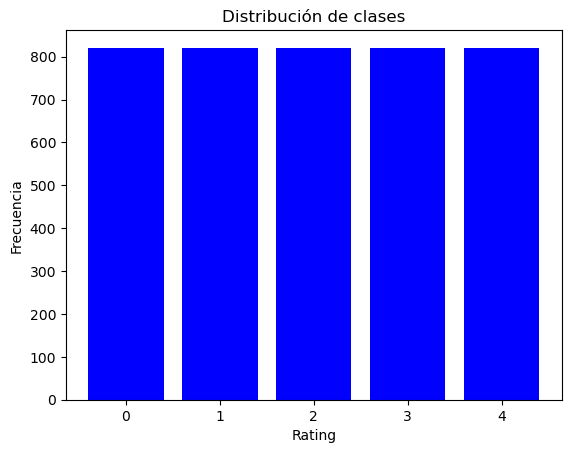

In [31]:
value_counts = df_balanced['Rating'].value_counts()
plt.bar(value_counts.index, value_counts.values, color='blue')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de clases')

# Mostrar el gráfico
plt.show()

In [32]:
df_balanced

,Review Text,Rating
0,I need to remember that this brand runs small....,3
1,I read the cleaning instructions label careful...,0
2,"So i bought this, even after seeing the other ...",0
3,The bra is comfortable and the design is good....,1
4,"This top is really cute online, but that's abo...",2
...,...,...
4100,I bought this dress for a dinner after my daug...,4
4101,I'm sure there's someone out there who will lo...,0
4102,I've been looking for a comfortable summer dre...,3
4103,Beautiful sweatshirt top that can be worn to w...,4


In [33]:
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [34]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [35]:
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [36]:
len(tokens)

1372203

In [37]:
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [38]:
# Obtener el diccionario de palabra (word) a índice y viceversa
# y observar la cantidad total del vocabulario
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')
index_word = tok.index_word
print(index_word)

tamaño de vocabulario : 14847
{1: 'the', 2: 'i', 3: 'and', 4: 'a', 5: 'it', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'on', 12: 'for', 13: 'of', 14: 'with', 15: 'was', 16: 'so', 17: 'my', 18: 'dress', 19: 'not', 20: 'that', 21: 'love', 22: 'size', 23: 'very', 24: 'have', 25: 'top', 26: 'fit', 27: 'are', 28: 'like', 29: 'be', 30: 'as', 31: 'me', 32: 'wear', 33: "it's", 34: 'great', 35: 'too', 36: "i'm", 37: 'or', 38: 'am', 39: 'just', 40: 'you', 41: 'would', 42: 'they', 43: 'up', 44: 'at', 45: 'fabric', 46: 'small', 47: 'color', 48: 'look', 49: 'if', 50: 'more', 51: 'really', 52: 'ordered', 53: 'little', 54: 'perfect', 55: 'will', 56: 'one', 57: 'these', 58: 'flattering', 59: 'well', 60: 'an', 61: 'soft', 62: 'out', 63: 'back', 64: 'because', 65: 'had', 66: 'can', 67: '\r', 68: 'comfortable', 69: 'cute', 70: 'nice', 71: 'than', 72: 'bought', 73: 'beautiful', 74: 'when', 75: 'all', 76: 'looks', 77: 'bit', 78: 'fits', 79: 'large', 80: 'shirt', 81: 'down', 82: 'which', 83: 'mate

In [39]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [40]:
# Determinar el tamaño de la sequencia máxima a procesar

# se puede explorar cuál es la secuencia más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


(array([ 21.,  15.,  26.,  22.,  39.,  54.,  78., 293., 147., 132., 189.,
        168., 195., 188., 180., 389., 204., 227., 225., 229., 240., 227.,
        254., 504., 249., 265., 243., 289., 238., 257., 503., 262., 278.,
        268., 287., 306., 258., 243., 494., 269., 252., 227., 266., 230.,
        229., 243., 506., 257., 231., 224., 236., 231., 229., 464., 212.,
        222., 220., 223., 204., 195., 195., 399., 171., 200., 197., 171.,
        186., 191., 178., 412., 206., 215., 244., 201., 255., 287., 600.,
        317., 350., 368., 367., 390., 346., 313., 639., 247., 246., 194.,
        144., 113.,  71.,  50.,  75.,  20.,   7.,  12.,   2.,   4.,   1.,
          1.]),
 array([  2.  ,   3.13,   4.26,   5.39,   6.52,   7.65,   8.78,   9.91,
         11.04,  12.17,  13.3 ,  14.43,  15.56,  16.69,  17.82,  18.95,
         20.08,  21.21,  22.34,  23.47,  24.6 ,  25.73,  26.86,  27.99,
         29.12,  30.25,  31.38,  32.51,  33.64,  34.77,  35.9 ,  37.03,
         38.16,  39.29,  40.42

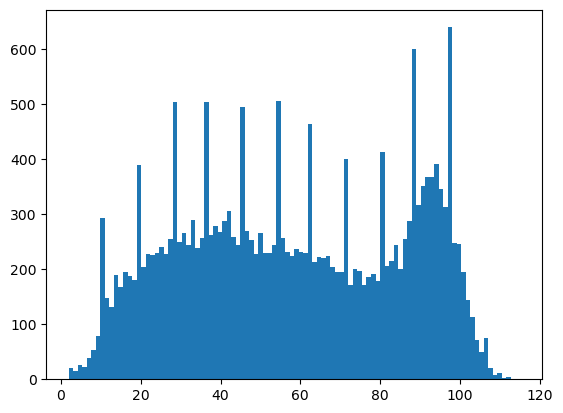

In [41]:
# y también explorar cómo es la distribución de tamaños de secuencias
plt.figure()
plt.hist(seqs_lenght,bins=100)

In [42]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [43]:
X.shape

(22641, 115)

In [44]:
y1 = df_reviews['Rating'].values
y = to_categorical(y1, num_classes=5)
print(y.shape)

(22641, 5)


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


In [47]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.metrics import AUC

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           29440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

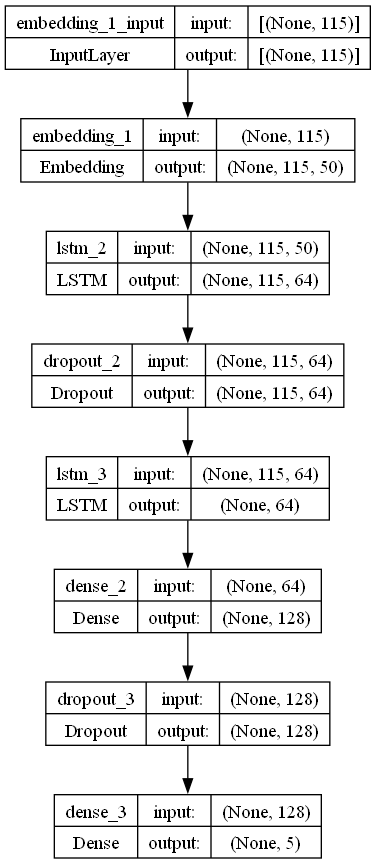

In [48]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 26s 51ms/step - loss: 1.0162 - accuracy: 0.5907 - val_loss: 0.9470 - val_accuracy: 0.6163
Epoch 2/5
453/453 [==============================] - 33s 74ms/step - loss: 0.8799 - accuracy: 0.6322 - val_loss: 0.9109 - val_accuracy: 0.6100
Epoch 3/5
453/453 [==============================] - 33s 74ms/step - loss: 0.8148 - accuracy: 0.6519 - val_loss: 0.9217 - val_accuracy: 0.6260
Epoch 4/5
453/453 [==============================] - 46s 103ms/step - loss: 0.7638 - accuracy: 0.6726 - val_loss: 0.9325 - val_accuracy: 0.6230
Epoch 5/5
453/453 [==============================] - 69s 153ms/step - loss: 0.7268 - accuracy: 0.6908 - val_loss: 0.9500 - val_accuracy: 0.6188


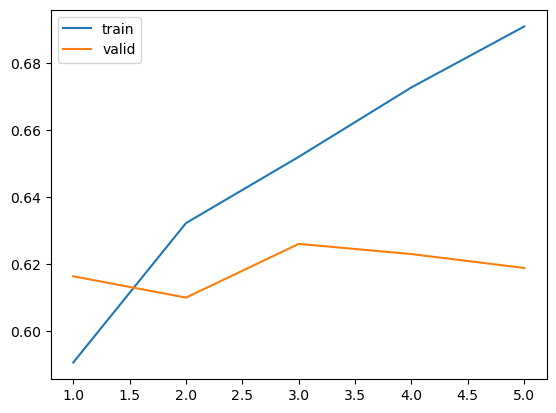

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [51]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 17ms/step - loss: 0.8869 - accuracy: 0.6410


[0.8868837356567383, 0.6409803628921509]

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [52]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [53]:
model_fasttext = FasttextEmbeddings()

In [54]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [55]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_4 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_4 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [56]:
hist2 = model2.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 38s 79ms/step - loss: 1.2264 - accuracy: 0.5525 - val_loss: 1.2311 - val_accuracy: 0.5468
Epoch 2/5
453/453 [==============================] - 50s 111ms/step - loss: 1.1854 - accuracy: 0.5528 - val_loss: 1.1847 - val_accuracy: 0.5490
Epoch 3/5
453/453 [==============================] - 54s 119ms/step - loss: 1.1537 - accuracy: 0.5561 - val_loss: 1.1545 - val_accuracy: 0.5504
Epoch 4/5
453/453 [==============================] - 92s 203ms/step - loss: 1.1228 - accuracy: 0.5618 - val_loss: 1.1480 - val_accuracy: 0.5540
Epoch 5/5
453/453 [==============================] - 56s 123ms/step - loss: 1.0996 - accuracy: 0.5665 - val_loss: 1.1316 - val_accuracy: 0.5578


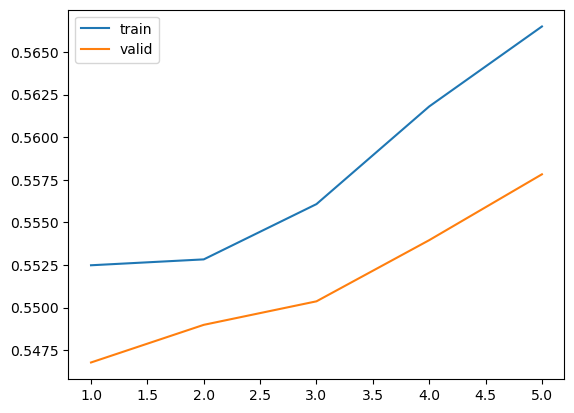

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [58]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 4s 31ms/step - loss: 1.0866 - accuracy: 0.5758


[1.0865724086761475, 0.5758445858955383]